In [43]:
import pickle
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Combine Simulated Data (DON'T NEED TO RUN!)
Combine all the simulated csv files (1-21) into a single dataframe.

In [2]:
# import glob
# files = glob.glob("../data/raw/simulated/simulatedDroneData*.csv")
# combined_df = pd.DataFrame()
# 
# for file in files:
#     df = pd.read_csv(file)
#     df["UUID"] = "None"
#     
#     identifier = str(uuid.uuid4())
#     for idx, row in df.iterrows():
#         if idx % 20 == 0:
#             identifier = str(uuid.uuid4())
#         df.at[idx, "UUID"] = identifier
# 
#     # print(f"{len(df)}: {len(df["UUID"].unique())}")
#     combined_df = pd.concat([combined_df, df])
# 
# grouped_df = combined_df.groupby("UUID")
# print(f"number of plots: {len(combined_df)}")
# print(f"number of UUIDs: {len(grouped_df)}")
# 
# size = grouped_df.size()
# print(f"\tmax track size: {max(size)}")
# print(f"\tmin track size: {min(size)}")
# print(f"\tmean track size: {size.mean()}")

### Save Combined Dataframe (DON'T NEED TO RUN!)

In [3]:
# combined_df.to_csv("../data/raw/simulated/combinedSimulatedData.csv", index=False)

### Read ECCO, Simulated, and GPS Data

In [4]:
gps_path = "../data/raw/gps/processedGPSData.csv"
simu_path = "../data/raw/simulated/combinedSimulatedData.csv"
ecco_path = "../data/raw/crane/ecco.csv"

gps_df = pd.read_csv(gps_path)
simu_df = pd.read_csv(simu_path)
ecco_df = pd.read_csv(ecco_path)

print(f"GPS: {gps_df.columns}")
print(f"SIMU: {simu_df.columns}")
print(f"ECCO: {ecco_df.columns}")

GPS: Index(['UpdateTime', 'Position_lat_', 'Position_lon_', 'Position_altMSL_',
       'Speed', 'UUID', 'Range', 'AZ', 'EL', 'RadialVelocity'],
      dtype='object')
SIMU: Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID'],
      dtype='object')
ECCO: Index(['UUID', 'Name', 'Create Time', 'Update Time', 'User Edit Time', 'Type',
       'Associated UUID', 'Note', 'Source Name', 'Source Class', 'Source LID',
       'Combat ID', 'Object ID', 'Range To Contact', 'Bearing To Contact',
       'Creator', 'Editor', 'AZ', 'EL', 'Range', 'Position (lat)',
       'Position (lon)', 'Position (alt MSL)', 'Origin Position (lat)',
       'Origin Position (lon)', 'Origin Position (alt MSL)', '2525', 'Speed',
       'Radar Cross Section', 'Closest Time', 'Course', 'Source ID',
       'Radial Velocity', 'Closest Distance', 'Deleted', 'Deleted Time',
       'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type',
     

/var/folders/sx/0gyr6z3573gdm1mnzzc8vw980000gn/T/ipykernel_81913/924411033.py:7: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,11,12,26,34,35,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  ecco_df = pd.read_csv(ecco_path)


### Analyze Tracks in Each File

In [5]:
for df, name in [(gps_df, "GPS"), (simu_df, "SIMULATED"), (ecco_df, "ECCO")]:
    print(f"* ============================== {name} ============================== *")
    
    grouped_df = df.groupby("UUID")
    print(f"number of plots: {len(df)}")
    print(f"number of UUIDs: {len(grouped_df)}")
    
    size = grouped_df.size()
    print(f"\tmax track size: {max(size)}")
    print(f"\tmin track size: {min(size)}")
    print(f"\tmean track size: {size.mean()}")


* ============================== GPS ============================== *
number of plots: 5365
number of UUIDs: 255
	max track size: 38
	min track size: 20
	mean track size: 21.03921568627451
* ============================== SIMULATED ============================== *
number of plots: 1708
number of UUIDs: 94
	max track size: 20
	min track size: 1
	mean track size: 18.170212765957448
* ============================== ECCO ============================== *
number of plots: 17587
number of UUIDs: 84
	max track size: 1017
	min track size: 2
	mean track size: 113.72619047619048


### Break ECCO Tracks Down

In [6]:
ecco_uuids = ecco_df["UUID"].unique()
for ecco_uuid in ecco_uuids:
    n_plots = len(ecco_df[ecco_df["UUID"] == ecco_uuid])
    
    if n_plots > 20:
        df = ecco_df[ecco_df["UUID"] == ecco_uuid]

        identifier = str(uuid.uuid4())
        for idx, row in ecco_df.iterrows():
            if idx % 20 == 0:
                identifier = str(uuid.uuid4())
            ecco_df.at[idx, "UUID"] = identifier


In [7]:
print(f"* ============================== ECCO ============================== *")

grouped_ecco = ecco_df.groupby("UUID")
print(f"number of plots: {len(ecco_df)}")
print(f"number of UUIDs: {len(grouped_ecco)}")

size = grouped_ecco.size()
print(f"\tmax track size: {max(size)}")
print(f"\tmin track size: {min(size)}")
print(f"\tmean track size: {size.mean()}")

* ============================== ECCO ============================== *
number of plots: 17587
number of UUIDs: 880
	max track size: 20
	min track size: 7
	mean track size: 19.985227272727272


### Match the Column Names

In [8]:
ecco_df_new = ecco_df.drop(columns=['Name', 'Create Time', 'User Edit Time', 'Type', 'Associated UUID', 
                      'Note', 'Source Name', 'Source Class', 'Source LID', 'Combat ID',
                      'Object ID', 'Range To Contact', 'Bearing To Contact', 'Creator',
                      'Editor', 'Origin Position (lat)', 'Origin Position (lon)', 
                      'Origin Position (alt MSL)', '2525', 'Radar Cross Section', 
                      'Closest Time', 'Course', 'Source ID', 'Closest Distance', 
                      'Deleted', 'Deleted Time', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 
                      'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks'])

ecco_df_new = ecco_df_new.rename(
    columns={
        'Update Time': 'UpdateTime',
        'Position (lat)': 'Position_lat_',
        'Position (lon)': 'Position_lon_',
        'Position (alt MSL)': 'Position_altMSL_',
        'Radial Velocity': 'RadialVelocity'
    }, 
    errors='raise'
)

ecco_df_new = ecco_df_new.reindex(columns=simu_df.columns)
ecco_df_new["Label"] = 0

gps_df = gps_df.reindex(columns=simu_df.columns)
gps_df["Label"] = 1

simu_df["Label"] = 1


print(ecco_df_new.columns)
print(simu_df.columns)
print(gps_df.columns)

print(f"\nGPS columns == simulated columns ? {all(gps_df.columns == simu_df.columns)}")
print(f"simulated columns == ECCO columns ? {all(simu_df.columns == ecco_df_new.columns)}")

Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')

GPS columns == simulated columns ? True
simulated columns == ECCO columns ? True


### Combine DataFrames into One

In [13]:
X = pd.concat([gps_df, ecco_df_new, simu_df])
print(f"Shape of combined df: {X.shape}")
print(X.columns)

Shape of combined df: (24660, 11)
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')


### Functions for Calculating Feature Vectors

In [16]:
def calculate_avg_speed(input_df):
    return input_df["Speed"].mean()

def calculate_std_speed(input_df):
    return input_df["Speed"].std()

def calculate_heading(input_df):
    delta_x = input_df["Position_lat_"] - input_df["Position_lat_"].shift(-1)
    delta_y = input_df["Position_lon_"] - input_df["Position_lon_"].shift(-1)   
    return np.arctan2(delta_y, delta_x)

def calculate_std_heading(input_df):
    heading = calculate_heading(input_df)
    return np.std(heading)

def calculate_osc_factor(input_df):
    heading = calculate_heading(input_df)
    theta = heading.shift(1) - heading

    om = theta.copy(deep=True)
    om[theta > 0.5] = 1
    om[theta < -0.5] = -1
    om[abs(theta) <= 0.5] = 0

    w = om.copy(deep=True)
    osc_number = 1
    for j in range(1, om.shape[0]-1):
        w[j] = osc_number    

### Form Feature Vector DataFrame

In [17]:
X_grouped = X.groupby("UUID")

avg_speed = calculate_avg_speed(X_grouped)
std_speed = calculate_std_speed(X_grouped)
std_heading = X_grouped.apply(calculate_std_heading)
mav_factor = avg_speed / std_heading

X_new = pd.DataFrame({
    'avg_speed': avg_speed,
    'std_speed': std_speed,
    'std_heading': std_heading,
    'mav_factor': mav_factor
})

X_new.replace([np.nan], 0, inplace=True)
X_new.replace([np.inf], 99999, inplace=True)
X_new.replace([-np.inf], -99999, inplace=True)

y_new = X_grouped["Label"].first()

In [34]:
print(X_new.head())
print(" ")

val_counts = y_new.value_counts()
print(val_counts)

check1 = val_counts[0] == len(ecco_df_new.groupby("UUID"))
print(f"\nBird labels in y_new == number of bird tracks ? {check1}")

check2 = val_counts[1] == (len(gps_df.groupby("UUID")) + len(simu_df.groupby("UUID")))
print(f"Drone labels in y_new == number of drone tracks ? {check2}")

check3 = len(X_new) == len(y_new)
print(f"Length of X_new == length of y_new ? {check3}")

                                      avg_speed  std_speed  std_heading  \
UUID                                                                      
00d07c7f-8dac-47ae-a9cc-f3ea57f5a2e0   9.711575   0.863517     2.471271   
01099908-45c3-42f7-949f-1c93afc3f177  12.265870   4.068952     1.589727   
011b46dc-e066-4e8d-9c8b-79dbc00e7e88  10.691114   4.478470     2.026199   
0140484d-dff0-4640-953c-0242e0c17374  11.871439   3.804042     1.641039   
014379ca-f34c-4d9d-b0cf-a0fbaed0f528  11.164096   5.810864     1.649139   

                                      mav_factor  
UUID                                              
00d07c7f-8dac-47ae-a9cc-f3ea57f5a2e0    3.929789  
01099908-45c3-42f7-949f-1c93afc3f177    7.715710  
011b46dc-e066-4e8d-9c8b-79dbc00e7e88    5.276438  
0140484d-dff0-4640-953c-0242e0c17374    7.234099  
014379ca-f34c-4d9d-b0cf-a0fbaed0f528    6.769652  
 
Label
0    880
1    349
Name: count, dtype: int64

Bird labels in y_new == number of bird tracks ? True
Drone label

### Train Model

In [36]:
# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2)

# define the classifier
rf = RandomForestClassifier()

# fit model on training data
rf.fit(X_train, y_train)

# use the trained model to generate predictions
rf_pred = rf.predict(X_test)

# get the confidence levels of each model
rf_confidence_pair = rf.predict_proba(X_test)

In [40]:
accuracy = metrics.accuracy_score(y_test, rf_pred)
print(f'accuracy = {100 * accuracy}')

accuracy = metrics.f1_score(y_test, rf_pred)
print(f'f1 score = {100 * accuracy}')

rf_confidence = [max(pair) for pair in rf_confidence_pair]
avg_rf_confidence = np.mean(rf_confidence)
med_rf_confidence = np.median(rf_confidence)

print(f'\naverage confidence level: {avg_rf_confidence}')
print(f'median confidence level: {med_rf_confidence}')

accuracy = 99.1869918699187
f1 score = 98.27586206896551

average confidence level: 0.9890243902439025
median confidence level: 1.0


### Visualize Decision Trees

number of trees in rf: 100


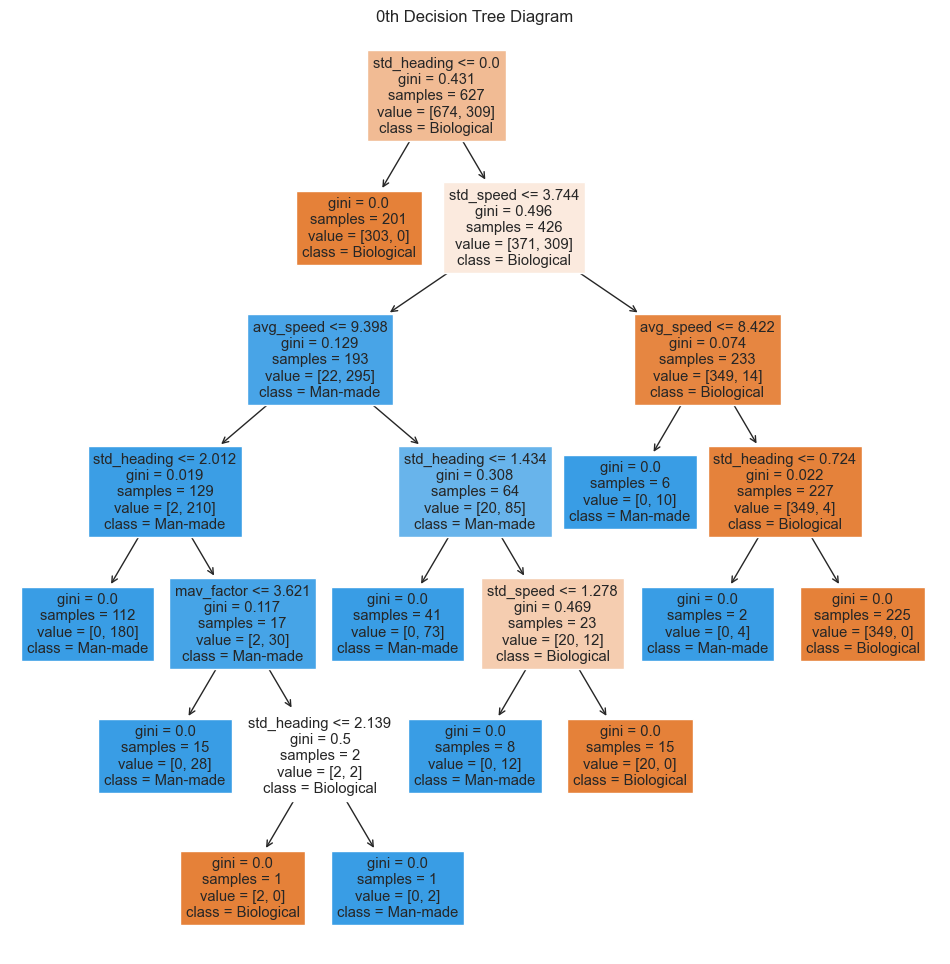

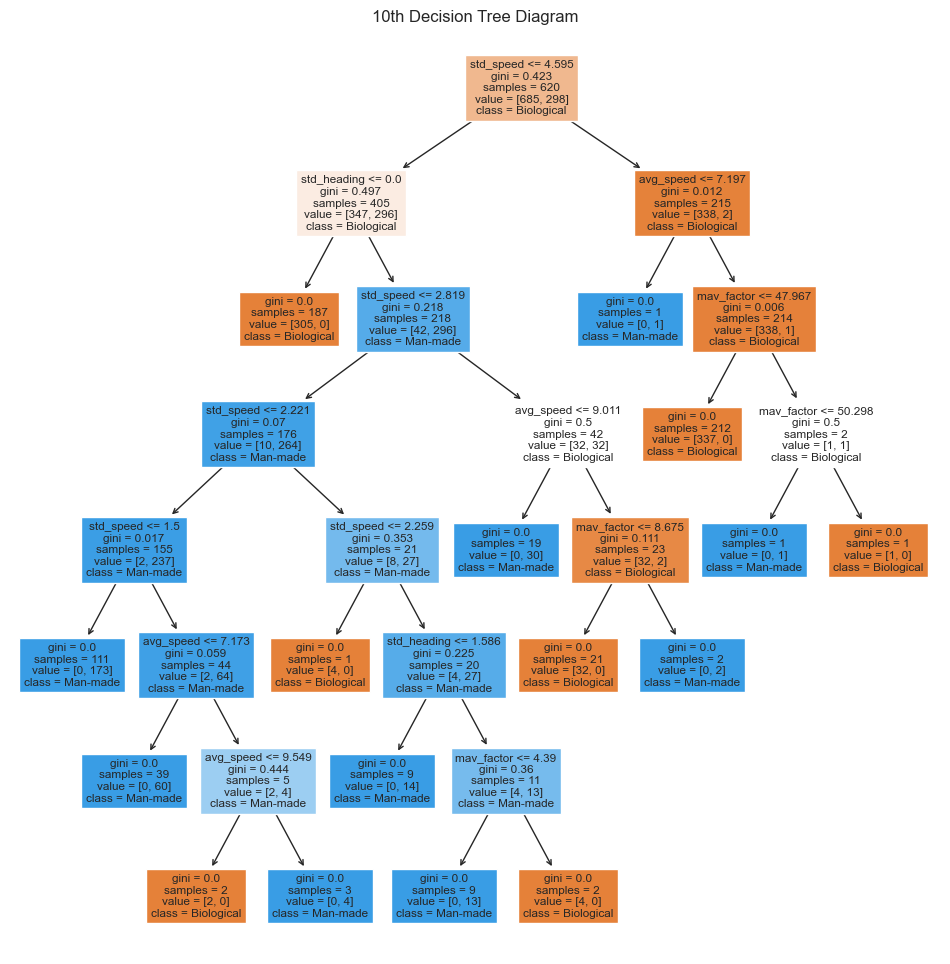

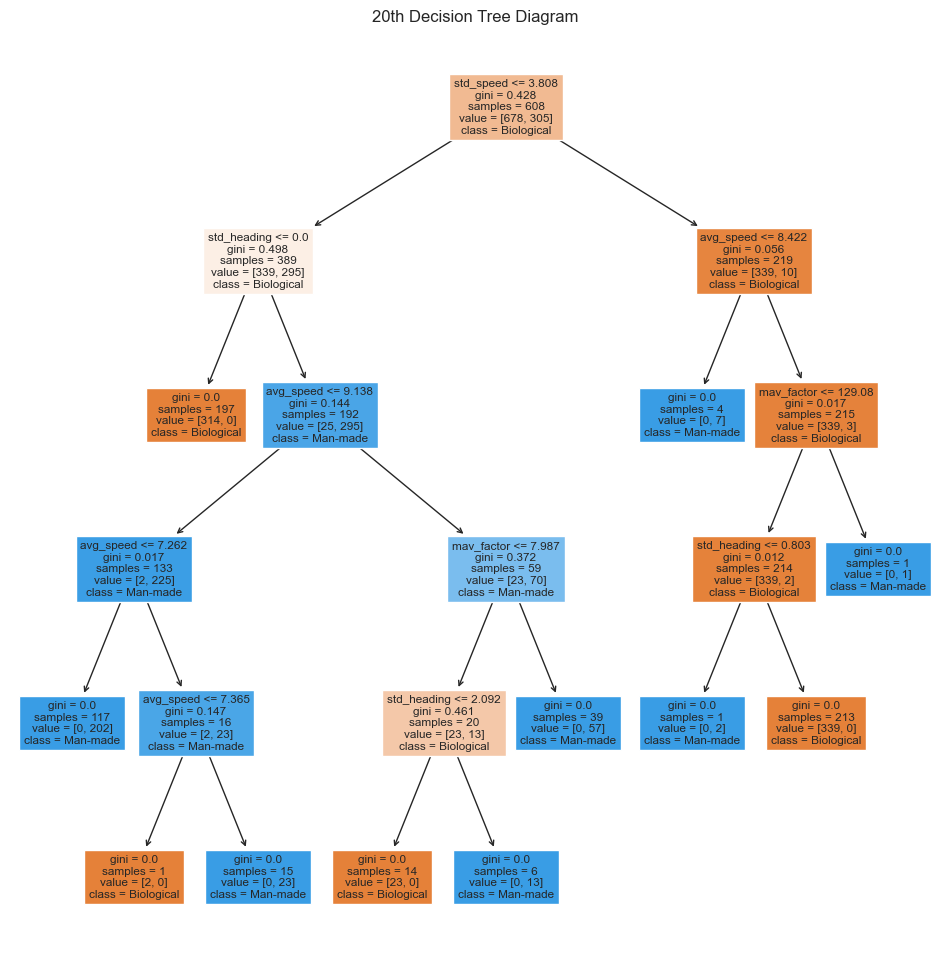

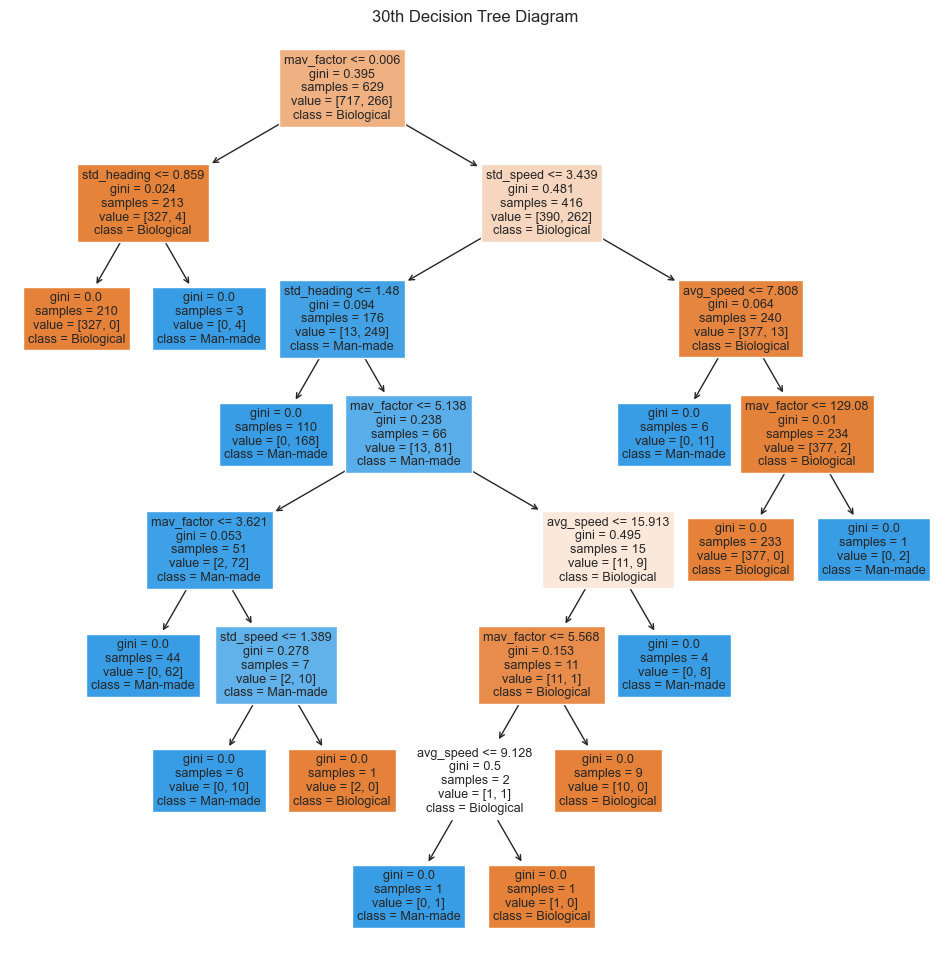

In [45]:
print(f'number of trees in rf: {len(rf.estimators_)}')

for i in [0, 10, 20, 30]:
    plt.figure(figsize=(12, 12))
    tree.plot_tree(rf.estimators_[i],
                feature_names = X_new.columns, 
                class_names=['Biological', 'Man-made'],
                filled = True)
    plt.title(f"{i}th Decision Tree Diagram")
    plt.show()

### Save Model

In [46]:
# filename = '../models/feb9_fv.sav'
# pickle.dump(rf, open(filename, 'wb'))